# Detectar transações fraudulentas de cartão de crédito

# Projeto de conclusão para formação **Nanodegree Engenheiro de Machine Learning** da Udacity

----
17.Nov.2018<br/>
Talita Shiguemoto


## Visão Geral do Projeto

Segundo a *Konduto*, a cada cinco segundos uma tentativa de fraude por cartão de crédito clonado ocorre em *e-commerces* brasileiros. De acordo mesma empresa, no ano passado o Brasil sofreu cerca de 6 milhões de compras fraudulentas. Comparado a outros, um estudo realizado em 2016 pela *Business Insider Intelligence* mostrou o Brasil em segundo lugar no ranking de maior porcentagem de consumidores expostos a transações fraudulentas via cartão de crédito nos últimos cinco anos.
Este estudo iniciou-se para entender como combater este cenário nacional, tendo como objetivo criar um algoritmo de detecção das transações com fraudes baseadas no conjunto de dados retirado do *Kaggle*.

In [1]:
# Importe as bibliotecas necessárias para este projeto
import pandas as pd
import numpy as np
from time import time
from IPython.display import display # Permite o uso de display() para DataFrames
import seaborn as sns\

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

#Pre-Processamento
from sklearn.preprocessing import MinMaxScaler # para preprocessamento
from imblearn.combine import SMOTETomek # sobreamostragem com SMOTE com Tome links
from sklearn.model_selection import train_test_split # separar os dados em treino e teste

#Modelos
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from xgboost.sklearn import XGBClassifier


#Metricas
from sklearn.model_selection import GridSearchCV # para otimizar os hiperparametros
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#Verificar normalidade
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import normaltest

# Mostre matplotlib no corpo do texto (bem formatado no Notebook)
%matplotlib inline

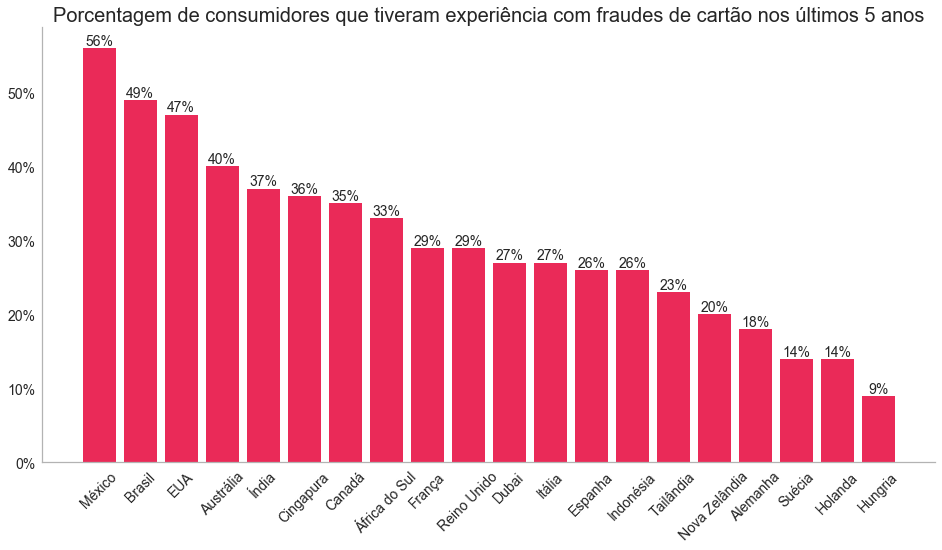

In [2]:
# Gráfico adaptado do Business Insider Intelligence
# Fonte:https://www.businessinsider.com/the-us-has-the-third-highest-card-fraud-rate-in-the-world-2016-7

paises = [
    'México', 'Brasil', 'EUA', 
    'Austrália', 'Índia', 'Cingapura', 
    'Canadá', 'África do Sul', 'França',
    'Reino Unido', 'Dubai', 'Itália',
    'Espanha', 'Indonésia', 'Tailândia',
    'Nova Zelândia', 'Alemanha', 'Suécia',
    'Holanda', 'Hungria'
]

taxa_fraude = [
    56, 49, 47, 40, 37,
    36, 35, 33, 29, 29,
    27, 27, 26, 26, 23,
    20, 18, 14, 14, 9    
]

# Design dos gráficos
palette=[
    '#ea2a58','#06598b', '#69c1b8',
    '#cbe6e7', '#78b343', '#f6dd10'
]

#bokeh da para fazer o gradiente

sns.set(style="white", palette=palette)
sns.set_style({'axes.edgecolor': '.7'})
# Plot o gráfico
fig, ax = plt.subplots(figsize=(16, 8))
plt.rcParams.update({'font.size': 14})
plt.bar(paises, taxa_fraude)

# Adicionando o Título
ax.set_title('Porcentagem de consumidores que tiveram experiência com \
fraudes de cartão nos últimos 5 anos', fontsize=20) 

# Formatando eixo Y
formatter = FuncFormatter(lambda taxa_fraude, pos: "%d%%" % (taxa_fraude))
ax.yaxis.set_major_formatter(formatter)
plt.yticks(size=14)

rects = ax.patches
# Criando os labels
labels = ["%d%%" %i for i in taxa_fraude]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height , label,
            ha='center', va='bottom')


ax.set_xticklabels(paises, fontsize=14, rotation = 45)
sns.despine()
plt.show()

## Descrição do Problema

Muitas transações por cartão de crédito são fraudulentas, o objetivo deste projeto é detectá-las baseado em um conjunto de dados histórico que já possui tal classificação (se foi fraude ou não). Cada transação possui algumas variáveis e com base nelas poderemos identificar quais atributos possuem maior influência para desvendar quais são fraudes ou não. Devido esse histórico com características o modelo criado será baseado em uma técnica de *Machine Learning* chamada aprendizagem supervisionada e poderá ser utilizado para futuras detecções de fraudes. 

O primeiro passo será pré-processar os dados para lidarmos com o desbalanceamento que, em outras palavras, é o fato de que normalmente em transações por cartão de crédito a taxa de fraudes é muito menor que a taxa de transações verdadeiras. Portanto, iremos utilizar uma técnica de subamostragem para resolver este impasse. Feito isso, será testado os algoritmos de Métodos de Ensemble (Random Forest, Gradient Boosting, XGBoost),Support Vector Machines e K-Nearest Neighbors, verificando qual deles terá melhor performance e resultados. O modelo final será escolhido embasado por algumas métricas (veja em **Métricas de avaliação**) e terá seus hiperparâmetros otimizados pelo *GridSearch*.


----
## Métricas de avaliação

Devido nosso conjunto ser desbalanceado a acurácia não é a melhor métrica para ser usada na avaliação do modelo. Para este estudo utilizaremos principalmente o AUC ROC para verificar a qualidade do algoritmo.


O *recall*, também chamado de ***True Positive Rate (TPR)***, é a proporção entre os Verdadeiros Positivos sobre todas os positivos classificados corretamente e os falsos negativos. Matematicamente representado por:

\begin{align}
\dot{Recall} & = 	\frac{TP}{TP+FN} 
\end{align}

Para entender o AUC é necessário compreender primeiro a curva do ***Receiver Operating Characteristic (ROC)***, que é um gráfico que mostra o desempenho de um modelo de classificação em todos os limites de classificação. Esta curva mostra dois parâmetros: o TPR e o False Positive Rate (FPR).

\begin{align}
\dot{FRP} & = 	\frac{FP}{TP+TN} 
\end{align}

Uma curva ROC traça TPR vs. FPR em diferentes limiares de classificação. Diminuir o limiar de classificação classifica mais itens como positivos, aumentando assim tanto os falsos positivos quanto os verdadeiros positivos. Em outras palavras, um modelo prediz a probabilidade de uma classe ser 1 ou 0, usando essas probabilidades é possível plotar um gráfico de distribuição como na figura abaixo, sendo a curva vermelha representando 0 e a verde para 1 , sendo 0.5 o limite entre as duas classes.

![Figura 2 - ROC](img/2.png)

Todos os valores positivos acima do limite (maiores que 0.5) serão True Positives (TP), e todos os valores negativos acima do limite serão False Positives (FP), uma vez que foram classificados incorretamente como positivos. Abaixo do limite, todos os valores negativos serão True Negatives (TN) e os positivos False Negatives (FN), uma vez que foram classificados incorretamente como negativos. Esse conceito é melhor demonstrado na figura a seguir.

![Figura 3 - TN, TP, FN, FP](img/3.png)

A curva AUC mede toda a área bidimensional por baixo de toda curva ROC. AUC fornece uma medida agregada de desempenho em todos os possíveis limites de classificação. Uma maneira de interpretar AUC é como a probabilidade de o modelo classificar um exemplo positivo aleatório mais do que um exemplo negativo aleatório. Um modelo cujas previsões são 100% erradas tem uma AUC de 0,0; enquanto um cujas previsões são 100% corretas tem uma AUC de 1,0, melhor visualizada abaixo:

![Figura 4 - ROC AUC](img/4.png)

Outra métrica utilizada para escolha do melhor modelo será a utilização do *Classification Report* do sklearn, trata-se de uma tabela de reporte com as principais métricas de avaliação para cada classe, sendo elas: recall, precision e *f1_score*.
O *precision* é a proporção entre os Verdadeiros Positivos sobre todas os positivos, sendo eles classificados corretamente ou não. Matematicamente representado por:

\begin{align}
\dot{Precision} & = 	\frac{TP}{TP+FP} 
\end{align}

O f1_score é á média harmônica que considera ambos: precision e recall, sendo sua fórmula expressada por:


\begin{align}
\dot{f1  	Score} & = 	\frac{2 x (Precision * Recall)}{Precision + Recall} 
\end{align}

----
## Exploração dos dados

In [3]:
''' Download link to this Dataset (144MB) 
https://www.kaggle.com/mlg-ulb/creditcardfraud/data '''
# Importar os dados e transformar em um DataFrame
df = pd.DataFrame(pd.read_csv("database/creditcard.csv"))
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Para ter uma ideia de os dados se comportam, vou verificar o tamanho do conjunto de dados, os tipos das variáveis, se há *missing values*, seu sumário estatístico e as distribuições

In [4]:
# Verificar tamanho do conjunto de dados
df.shape

(284807, 31)

In [5]:
# Verificar tipos de variávies
# verificar missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [6]:
# Verificar sumário estatístico
df.describe().round(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


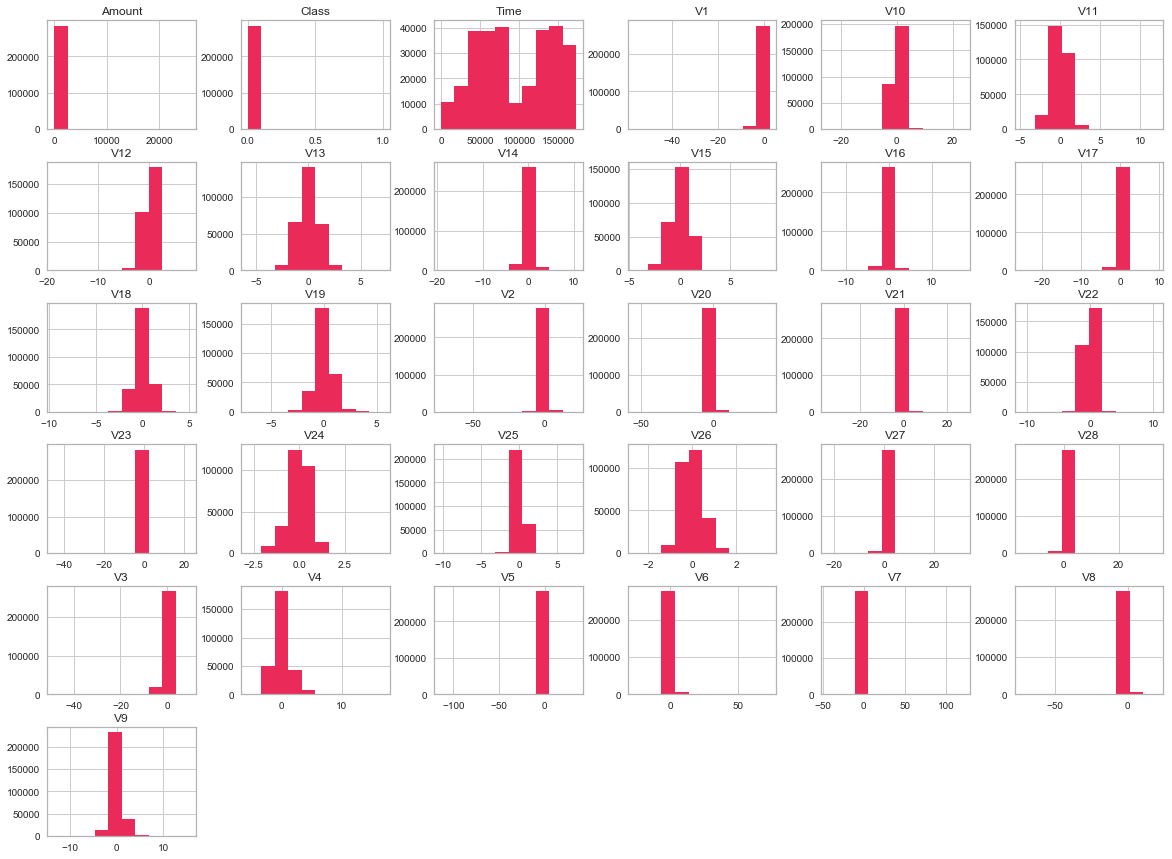

In [7]:
#Verificando a distribuição das features
fig = plt.figure(figsize = (20,15))
ax = fig.gca()
df.hist(column=df.columns, ax=ax);

Muitas variáveis são assiméticas (*skewed*), contudo as *features* anônimas já são fruto de um pré-processamento (a transformação via PCA), por isso vamos verificar melhor a *feature Amount* que tem uma distribuição assimétrica à direita (*positive skewed*).

A distribuição de Amount não é normal
D’Agostino’s K^2 Test: Statistics=588235.01, p=0.00



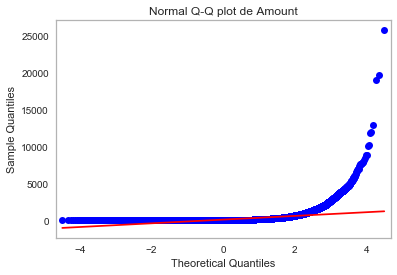

In [8]:
#Testando se tem distribuição normal via D'Agostino's K^2 teste
# Não iremos usar Shapiro por N > 5000
# Plotando o Normal Q-Q Plot
qqplot(df.Amount, line='s')
plt.title("Normal Q-Q plot de Amount")
stat, p = normaltest(df.Amount)
alpha = 0.05
if (p > alpha):
    print('A distribuição de Amount é normal')
    print('D’Agostino’s K^2 Test: Statistics={:.2f}, p={:.2f}\n'.format(stat, p))
else:
    print('A distribuição de Amount não é normal')
    print('D’Agostino’s K^2 Test: Statistics={:.2f}, p={:.2f}\n'.format(stat, p))

C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'norm_list' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'norm_list' kwarg is deprecated, and has been "


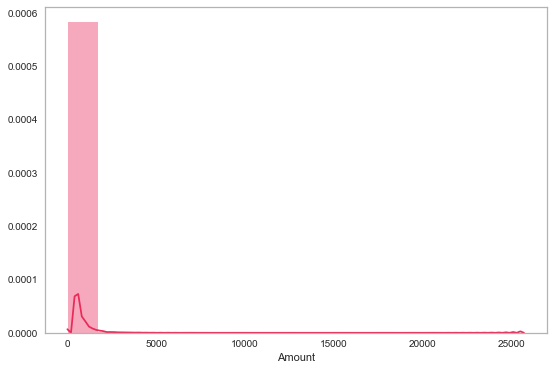

In [9]:
plt.figure(figsize=(9,6))
sns.distplot(df['Amount'], bins = 15);

Verificando o *target* Class é notável seu desbalanceamento, para verificar um pouco mais a fundo será plotado separadamente, verificando também a taxa de 1 para o total

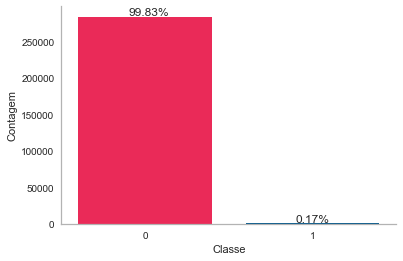

In [10]:
#Plotar gráfico para verificar desbalanceamento
ax = sns.countplot('Class', data = df, saturation=1)
ax.set_xlabel('Classe')
ax.set_ylabel('Contagem')
plt.rcParams.update({'font.size': 12})
for i in ax.patches:
    ax.annotate('{:.2f}%'.format(100 * i.get_height() / df.shape[0]),
                (i.get_x() + 0.3, i.get_height() + 2000))

sns.despine();

In [11]:
pd.value_counts(df['Class'])

0    284315
1       492
Name: Class, dtype: int64

Por causa deste desbalanceamento vamos ter que utilizar algumas técnicas de *sobreamostragem* ou *subamostragem*, para contornar este problema, falaremos deste tópico mais a fundo em breve. 
Primeiro vamos olhar melhor o comportamento dos dados.

Um ponto interessante é verificar na medida do tempo, como o *Amount* se comporta de acordo com a *Class*

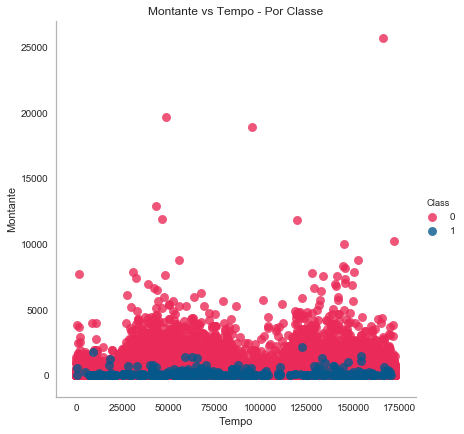

In [12]:
# Plotar gráfico de Amount por Time, separado por Class
sns.lmplot(
    x = 'Time', y ='Amount',
    data = df, hue = "Class",
    fit_reg = False, size = 6,
    scatter_kws = {"s": 80}
); 
ax = plt.gca()
ax.set_xlabel("Tempo")
ax.set_ylabel("Montante")
ax.set_title("Montante vs Tempo - Por Classe");

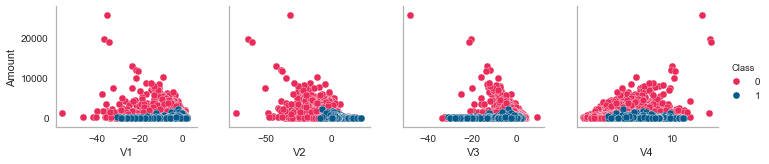

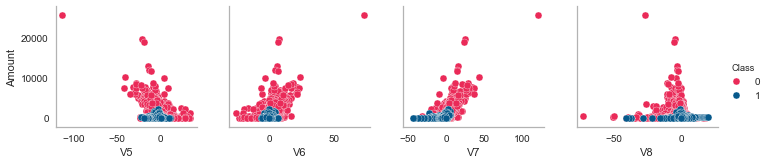

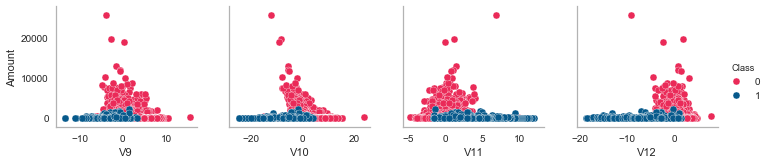

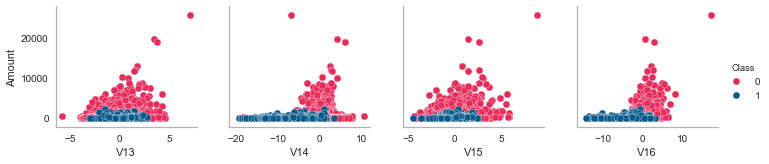

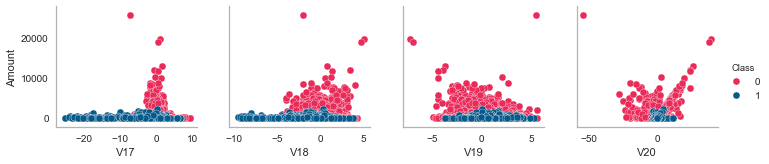

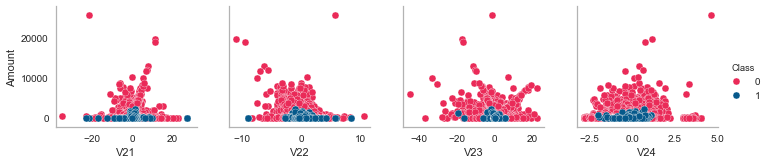

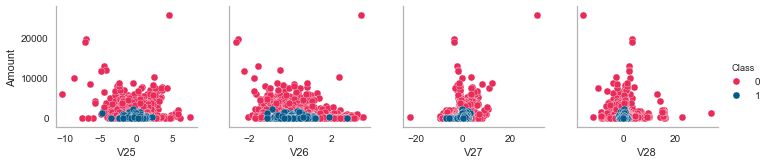

In [13]:
# Plotar gráfico de Amount por cada Feature 
# separado por Class
sns.pairplot(
    df, hue="Class", 
    y_vars=['Amount'],
    x_vars=["V1", "V2", "V3", "V4"]
);
sns.pairplot(
    df, hue="Class", 
    y_vars=['Amount'],
    x_vars=["V5", "V6", "V7", "V8"]
);
sns.pairplot(
    df, hue="Class", 
    y_vars=['Amount'],
    x_vars=["V9", "V10", "V11", "V12"]
);
sns.pairplot(
    df, hue="Class", 
    y_vars=['Amount'],
    x_vars=["V13", "V14", "V15", "V16"]
);
sns.pairplot(
    df, hue="Class", 
    y_vars=['Amount'],
    x_vars=["V17", "V18", "V19", "V20"]
);
sns.pairplot(
    df, hue="Class", 
    y_vars=['Amount'],
    x_vars=["V21", "V22", "V23", "V24"]
);
sns.pairplot(
    df, hue="Class", 
    y_vars=['Amount'],
    x_vars=["V25", "V26", "V27", "V28"]
);

O dataset para preservar a confidencialidade possui features transformadas via PCA anteriormente, portanto é esperado que elas não possuam correlação entre si. Para verificar tal suposição o Mapa de Calor foi plotado a seguir, que comprava que sim, as features não possuem correlação.

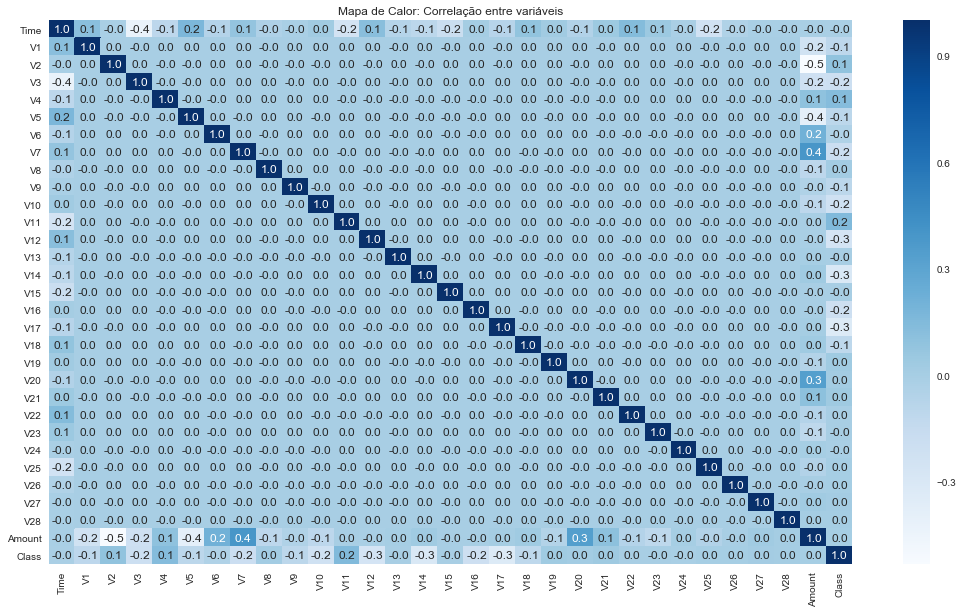

In [14]:
plt.figure(figsize=(18,10))
plt.title('Mapa de Calor: Correlação entre variáveis')
sns.heatmap(df.corr(), annot=True, cmap='Blues', fmt='.1f');

----
## Algoritmos e Técnicas

Neste projeto testaremos uma série de algoritmos da biblioteca do sklearn na intenção de optar pelo o que obtiver um melhor resultado nas análises. Os modelos utilizados neste estudo são:

* **Support Vector Machines (SVM)**: utiliza uma técnica chamada de kernel para transformar os dados e encontra um limite ideal entre as saídas possíveis. Possui uma alta acuracidade, não é sensível a não linearidade dos dados, baixo risco de overfitting usando kernels corretos, trabalha bem com dados dimensionais elevados. 

* **Regressão Logística (RL)**: estima a probabilidade associada à ocorrência de um determinado evento devido algumas features. Possui alto grau de confiabilidade e não é necessário supor normalidade multicolinearidade.  

* **Random Forest (RF)**: um método ensemble utilizado para construir um modelo baseado em múltiplas DT durante a fase de treino. Possui baixo risco de overfitting, ele costuma ser rápido para treinar, contudo lento para predição. Melhor escalabilidade quando o conjunto de dados é menor, no nosso caso de usaremos subamostragem para isso. 

* **XGBoost (XGB)**: é uma implementação avançada do GB, contudo mais rápido e com alto poder preditivo. Possui uma variedade de regularizações que reduzem o overfitting e melhoram o desempenho geral.


As técnicas utilizadas neste projeto são:
* **GridSearch**: otimiza os hiperparametros dos modelos para encontrar o modelo mais otimizado possível. 

* **Under-sampling**: retira da modelagem linhas da classe majoritária, para evitar desbalanceamento. 

* **Over-sampling**: replica linhas da classe minoritária ou gera dados sintéticos, para evitar desbalanceamento.

* **Synthetic Minority Over-Sampling Technique (SMOTE)**: Utilizado para sintetizar os dados no over-sampling.  

* **Transformação em Log**: utilizado para normalizar os dados com distribuição assimétrica. 

* **MinMaxScaler**: padroniza as features na mesma escala. 



----
## Benchmark

Utilizando o mesmo conjunto de dados no estudo mais votado no Kaggle, o autor utilizou uma Regressão Logística para criar o modelo que obteve uma acurácia e recall próximo de 93% e, conforme a Figura 9, obteve a Area Under the ROC Curve (AUC) em aproximadamente 0,95. Para contornar o problema de desbalanceamento o autor fez uma submamostragem e executou tanto o treino do algoritmo como teste nos dados subamostrados, obtendo o 0,95 de ROC AUC.

![figura](img/benchmark.png)

----
## Pré-Processamento dos dados
A *feature* Amount tem uma distribuição assimétrica, devido a isso o primeiro passo é uma transformação em log e depois um *Feature Scaling*, que consistirá em reescalonar os dados para obter uma distribuição normal com média de zero e desvio padrão de um. A técnica utilizada para esta etapa será o ***MinMaxScaler*** do sklearn, que transformará os dados em uma escala de 0 a 1.

Será criado um novo dataframe para armazenas os dados copiados mais o reescalonado, retirado das análises a coluna original Amount.

In [15]:
df_scaled = pd.DataFrame(data = df, copy = True)
df_scaled['logAmount'] = df_scaled['Amount'].apply(lambda x: np.log(x + 1))
df_scaled['MinLogAmount'] = MinMaxScaler().fit_transform(df_scaled['logAmount'].values.reshape(-1, 1))
df_scaled = df_scaled.drop(['Time','Amount', 'logAmount'],axis=1)
df_scaled.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,MinLogAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.493873
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.128583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,0.584923
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.475117
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.419792


### Divisão dos dados em treinamento e teste
Uma vez que temos os dados prontos para analisar, faz-se necessário dividir os dados entre conjuntos de treinamento e de teste, em uma proporção de 70% para treinamento e 30% para teste. Depois de fazer isso temos que tratar o desbalanceamento dos dados, contudo somente nos dados de treinamento.


### Desbalanceamento

Para lidar com o desbalanceamento dos dados será utilizado três técnicas: Undersampling aleatória, Oversampling aleatório e Oversampling por dados sintéticos com a técnica *SMOTE com Tomek links*.

**UnderSampling**
Esta técnica consiste em retirar da modelagem linhas da classe majoritária (*Class = 0*) de forma aleatória. Será criado dois novos dataframes, um com a mesma quantia de recursos pro Class (50%) e outra com 66% Transações normais e 33% fraudulentas

In [16]:
data_X = df_scaled.iloc[:, df_scaled.columns != 'Class']
data_y = df_scaled.iloc[:, df_scaled.columns == 'Class']

# Dividir em teste e treinamento
X_train, X_test, y_train, y_test = train_test_split(data_X, 
                                                    data_y, 
                                                    test_size = 0.3, 
                                                    random_state = 0)

In [17]:
#Armazenar em variáveis o count de cada Class
contagem_classe_0, contagem_classe_1 = y_train.Class.value_counts()
df_train = X_train.join(y_train, lsuffix='X_train', rsuffix='y_train')
#Separar em dataframes cada Class
df_class_0 = df_train[df_train['Class'] == 0]
df_class_1 = df_train[df_train['Class'] == 1]

Qtd Under-sampling randomizado:
1    345
0    345
Name: Class, dtype: int64


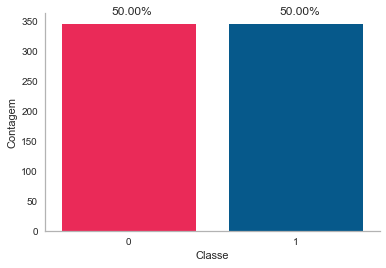

In [18]:
df_class_0_undersample = df_class_0.sample(contagem_classe_1)
df_undersample50 = pd.concat([df_class_0_undersample, df_class_1], axis=0)

under50_X = df_undersample50.iloc[:, df_undersample50.columns != 'Class']
under50_y = df_undersample50.iloc[:, df_undersample50.columns == 'Class']

#Mostrar quantidade de rows para cada class
print('Qtd Under-sampling randomizado:')
print(df_undersample50.Class.value_counts())

#Plotar gráfico para verificar desbalanceamento
ax = sns.countplot('Class', data = df_undersample50, saturation=1)
ax.set_xlabel('Classe')
ax.set_ylabel('Contagem')
plt.rcParams.update({'font.size': 12})
for i in ax.patches:
    ax.annotate('{:.2f}%'.format(100 * i.get_height() / df_undersample50.shape[0]),
                (i.get_x() + 0.3, i.get_height()+ 15))

sns.despine();

Qtd Under-sampling randomizado:
0    690
1    345
Name: Class, dtype: int64


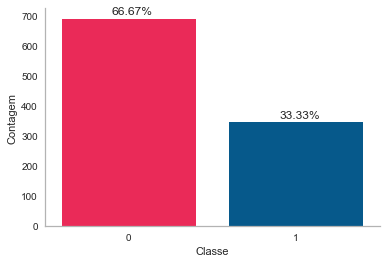

In [19]:
df_class_0_undersample = df_class_0.sample(contagem_classe_1*2)
df_undersample33 = pd.concat([df_class_0_undersample, df_class_1], axis=0)

under33_X = df_undersample33.iloc[:, df_undersample33.columns != 'Class']
under33_y = df_undersample33.iloc[:, df_undersample33.columns == 'Class']

#Mostrar quantidade de rows para cada class
print('Qtd Under-sampling randomizado:')
print(df_undersample33.Class.value_counts())

#Plotar gráfico para verificar desbalanceamento
ax = sns.countplot('Class', data = df_undersample33, saturation=1)
ax.set_xlabel('Classe')
ax.set_ylabel('Contagem')
plt.rcParams.update({'font.size': 12})
for i in ax.patches:
    ax.annotate('{:.2f}%'.format(100 * i.get_height() / df_undersample33.shape[0]),
                (i.get_x() + 0.3, i.get_height()+ 15))

sns.despine();

**OverSampling Aleatório**
Esta técnica replica de forma aleatória linhas da classe minoritária (*Class = 1*). Será criado dois novos dataframes, um com a mesma quantia de recursos pro Class (50%) e outra com 66% Transações normais e 33% fraudulentas.


Qtd Over-sampling randomizado:
1    199019
0    199019
Name: Class, dtype: int64


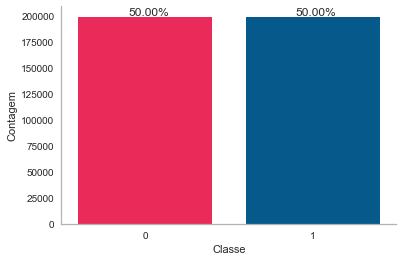

In [20]:
df_class_1_oversample = df_class_1.sample(contagem_classe_0, replace=True)
df_oversample50 = pd.concat([df_class_1_oversample, df_class_0], axis=0)

over50_X = df_oversample50.iloc[:, df_oversample50.columns != 'Class']
over50_y = df_oversample50.iloc[:, df_oversample50.columns == 'Class']

#Mostrar quantidade de rows para cada class
print('Qtd Over-sampling randomizado:')
print(df_oversample50.Class.value_counts())

#Plotar gráfico para verificar desbalanceamento
ax = sns.countplot('Class', data = df_oversample50, saturation=1)
ax.set_xlabel('Classe')
ax.set_ylabel('Contagem')
plt.rcParams.update({'font.size': 12})
for i in ax.patches:
    ax.annotate('{:.2f}%'.format(100 * i.get_height() / df_oversample50.shape[0]),
                (i.get_x() + 0.3, i.get_height()+ 1500))

sns.despine();

Qtd Over-sampling randomizado:
0    199019
1     99509
Name: Class, dtype: int64


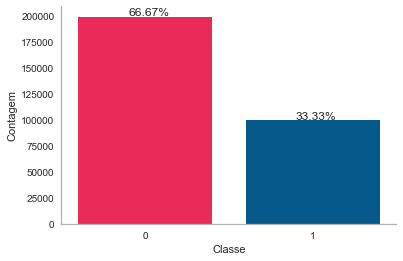

In [21]:
df_class_1_oversample = df_class_1.sample(int(contagem_classe_0/2), replace=True)
df_oversample33 = pd.concat([df_class_1_oversample, df_class_0], axis=0)

over33_X = df_oversample33.iloc[:, df_oversample33.columns != 'Class']
over33_y = df_oversample33.iloc[:, df_oversample33.columns == 'Class']

#Mostrar quantidade de rows para cada class
print('Qtd Over-sampling randomizado:')
print(df_oversample33.Class.value_counts())

#Plotar gráfico para verificar desbalanceamento
ax = sns.countplot('Class', data = df_oversample33, saturation=1)
ax.set_xlabel('Classe')
ax.set_ylabel('Contagem')
plt.rcParams.update({'font.size': 12})
for i in ax.patches:
    ax.annotate('{:.2f}%'.format(100 * i.get_height() / df_oversample33.shape[0]),
                (i.get_x() + 0.3, i.get_height()+ 1500))

sns.despine();

**OverSampling SMOTE com Tomek Links**
Esta técnica gera dados sintéticos por SMOTE, que será implementado junto com *Tomek links* para evitar o aumento de variância causada por algumas técnicas de geração de dados sintéticos

Será criado dois novos dataframes, um com a mesma quantia de recursos pro Class (50%) e outra com 66% Transações normais e 33% fraudulentas.

In [22]:
features_X = df_scaled.iloc[:, df_scaled.columns != 'Class']
target_y = df_scaled.iloc[:, df_scaled.columns == 'Class']

Total de linhas nos dados originais:199364
Qtd de classes por SMOTE with Tomek links:
1    199019
0    199019
Name: Class, dtype: int64


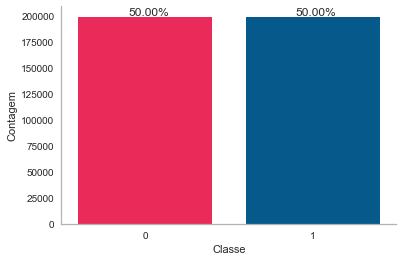

In [23]:
smoteTomek = SMOTETomek(random_state=42)
smote50_X,smote50_y = smoteTomek.fit_sample(X_train, y_train.values.ravel() )

smote50_y = pd.DataFrame(smote50_y)
smote50_y.columns= ['Class']
smote50_X = pd.DataFrame(smote50_X)
smote50_X.columns = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'MinLogAmount']
df_Smote50 = pd.concat([smote50_y, smote50_X], axis=1)

#Mostrar quantidade de rows para cada class
print('Total de linhas nos dados originais:{}'\
      .format(X_train.shape[0]))
#Mostrar quantidade de rows para cada class
print('Qtd de classes por SMOTE with Tomek links:')
print(df_Smote50.Class.value_counts())


#Plotar gráfico para verificar desbalanceamento
ax = sns.countplot('Class', data = df_Smote50, saturation=1)
ax.set_xlabel('Classe')
ax.set_ylabel('Contagem')
plt.rcParams.update({'font.size': 12})
for i in ax.patches:
    ax.annotate('{:.2f}%'.format(100 * i.get_height() / df_Smote50.shape[0]),
                (i.get_x() + 0.3, i.get_height()+ 1500))

sns.despine();

C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


Total de linhas nos dados originais:199364
Qtd de classes por SMOTE with Tomek links:
0    199019
1     99509
Name: Class, dtype: int64


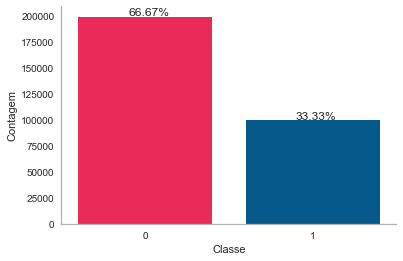

In [24]:
smoteTomek = SMOTETomek(random_state=42,ratio=0.5)
smote33_X,smote33_y = smoteTomek.fit_sample(X_train, y_train.values.ravel() )

smote33_y = pd.DataFrame(smote33_y)
smote33_y.columns= ['Class']
smote33_X = pd.DataFrame(smote33_X)
smote33_X.columns = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'MinLogAmount']
df_Smote33 = pd.concat([smote33_y, smote33_X], axis=1)

#Mostrar quantidade de rows para cada class
print('Total de linhas nos dados originais:{}'\
      .format(X_train.shape[0]))
#Mostrar quantidade de rows para cada class
print('Qtd de classes por SMOTE with Tomek links:')
print(df_Smote33.Class.value_counts())


#Plotar gráfico para verificar desbalanceamento
ax = sns.countplot('Class', data = df_Smote33, saturation=1)
ax.set_xlabel('Classe')
ax.set_ylabel('Contagem')
plt.rcParams.update({'font.size': 12})
for i in ax.patches:
    ax.annotate('{:.2f}%'.format(100 * i.get_height() / df_Smote33.shape[0]),
                (i.get_x() + 0.3, i.get_height()+ 1500))

sns.despine();

Agora temos 6 conjunto de dados pra treinar os algoritmos verificando qual deles tem melhor resultado.
Um breve resumo dos conjuntos de dados para facilicar entendimento:
* `df_undersample50`: resultante de um UnderSampling aleatório. Class 1: 50% e Class 0: 50%.
* `df_undersample33`: resultante de um UnderSampling aleatório. Class 1: 33% e Class 0: 67%.
* `df_oversample50`: resultante de um OverSampling aleatório. Class 1: 50% e Class 0: 50%.
* `df_oversample33`:resultante de um OverSampling aleatório. Class 1: 33% e Class 0: 67%.
* `df_Smote50`: resultante de um SMOTE com Tomek links. Class 1: 50% e Class 0: 50%.
* `df_Smote33`:resultante de um SMOTE com Tomek links. Class 1: 33% e Class 0: 67%.


----
## Implementação

Nesta etapa criaremos uma função para aplicar um algoritmo classificador sem nenhum parâmetro otimizado e já mostrar os resultados de Recall, AUC ROC e o tempo que o algoritmo usa para treinar e prever os dados, baseados nos datasets resultantes de reamostragem. O intuito desta etapa é verificar qual o algoritmo e técnica de reamostragem que tem melhor performance nos dados de treinamento e teste para encontrarmos o melhor modelo.  

In [25]:
def train_predict(learner, X_train, X_test, y_train, y_test): 

    results = {}
      
    # Fit no algoritmo calculando quanto tempo precisou para treinar
    start = time() 
    learner = learner.fit(X_train,y_train.values.ravel())    
    end = time()     
    results['time_train'] = end - start
        
    # Faz a predição do algoritmo calculando quanto tempo precisou para prever 
    start = time()
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time()
    results['time_pred'] = end - start
                   
    # Calcula o Recall Score nos dados de teste
    results['recall_score_test'] = recall_score(y_test, predictions_test)
            
    # Calcula o ROC_AUC nos dados de teste
    results['roc_auc_test'] = roc_auc_score(y_test, predictions_test)
    
    # Calcula Precision, Recall e f1_Score por classe nos dados de teste
    classification = classification_report(y_test, predictions_test)
    lines = classification.split('\n')
    class_0 = lines[2].split('     ')
    class_1 = lines[3].split('     ')
    results['precision 0'] = float(class_0[3])
    results['recall 0'] = float(class_0[4])
    results['f1_score 0'] = float(class_0[5])
    results['precision 1'] = float(class_1[3])
    results['recall 1'] = float(class_1[4])
    results['f1_score 1'] = float(class_1[5])
       
    # Retorna o resultado
    return results

### Dataframe 1: df_Smote50

In [26]:
# Inicializando os modelos
clf_SVM = SVC(random_state=96)
clf_RL= LogisticRegression(random_state=96)
clf_RF = RandomForestClassifier(random_state=96)
clf_XGB = XGBClassifier(random_state=96)


# Coleta os resultados dos algoritmos
results = {}
for clf in [
    clf_SVM, clf_RL, 
    clf_RF, clf_XGB
]:
    clf_model = clf.__class__.__name__
    results[clf_model] = train_predict(clf, smote50_X, X_test, smote50_y, y_test)

#Cria uma dataframe para os resultados
df_score = pd.DataFrame(results)  
df_score

C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,SVC,LogisticRegression,RandomForestClassifier,XGBClassifier
f1_score 0,1.000000,0.990000,1.000000,1.000000
f1_score 1,0.500000,0.110000,0.850000,0.250000
precision 0,1.000000,1.000000,1.000000,1.000000
precision 1,0.390000,0.060000,0.890000,0.150000
recall 0,1.000000,0.980000,1.000000,0.990000
recall 1,0.700000,0.920000,0.810000,0.880000
recall_score_test,0.700680,0.918367,0.809524,0.877551
roc_auc_test,0.849385,0.946827,0.904674,0.934373
time_pred,174.679000,0.313000,0.868174,1.857371
time_train,2693.445000,6.519000,41.859732,139.034801


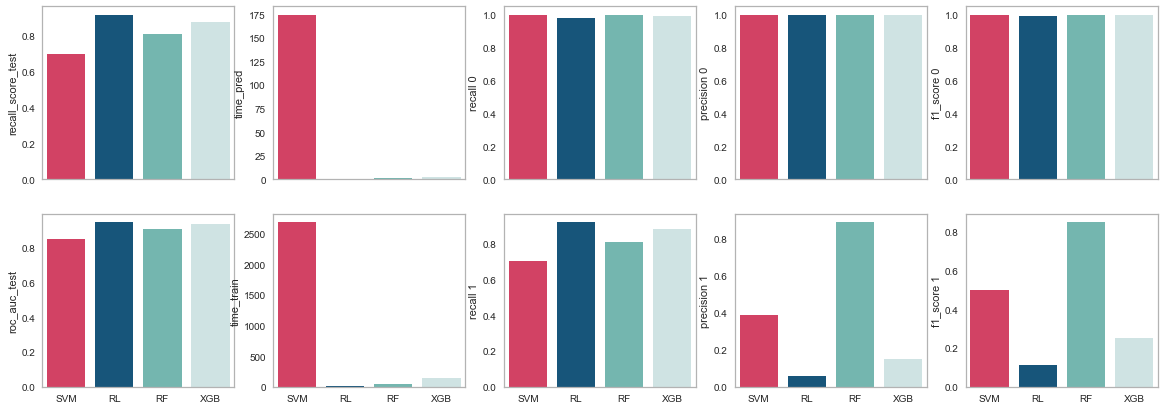

In [27]:
#Transpontando o dataset para plotar
df_scoreT = df_score.T
#Renomeando os algoritmos
df_scoreT.rename(index={
    'SVC': 'SVM',
    'LogisticRegression': 'RL',
    'RandomForestClassifier': 'RF',
    'XGBClassifier': 'XGB'
    
}, inplace=True)

#Verificando a distribuição das features
fig, axes = plt.subplots(2, 5, figsize=(20, 7), sharex=True)
sns.barplot( x=df_scoreT.index, y='recall_score_test', 
            data=df_scoreT, ax=axes[0, 0], palette=palette)
sns.barplot( x=df_scoreT.index, y='roc_auc_test', 
            data=df_scoreT, ax=axes[1, 0], palette=palette)

sns.barplot( x=df_scoreT.index, y='time_pred', 
            data=df_scoreT, ax=axes[0, 1], palette=palette)
sns.barplot( x=df_scoreT.index, y='time_train', 
            data=df_scoreT, ax=axes[1, 1], palette=palette)

sns.barplot( x=df_scoreT.index, y='recall 0', 
            data=df_scoreT, ax=axes[0, 2], palette=palette)
sns.barplot( x=df_scoreT.index, y='recall 1', 
            data=df_scoreT, ax=axes[1, 2], palette=palette);

sns.barplot( x=df_scoreT.index, y='precision 0', 
            data=df_scoreT, ax=axes[0, 3], palette=palette)
sns.barplot( x=df_scoreT.index, y='precision 1', 
            data=df_scoreT, ax=axes[1, 3], palette=palette);

sns.barplot( x=df_scoreT.index, y='f1_score 0', 
            data=df_scoreT, ax=axes[0, 4], palette=palette)
sns.barplot( x=df_scoreT.index, y='f1_score 1', 
            data=df_scoreT, ax=axes[1, 4], palette=palette);


### Dataframe 2: df_Smote33

In [28]:
# Inicializando os modelos
clf_SVM = SVC(random_state=96)
clf_RL= LogisticRegression(random_state=96)
clf_RF = RandomForestClassifier(random_state=96)
clf_XGB = XGBClassifier(random_state=96)

# Coleta os resultados dos algoritmos
results = {}
for clf in [
    clf_SVM, clf_RL, 
    clf_RF, clf_XGB
]:
    clf_model = clf.__class__.__name__
    results[clf_model] = train_predict(clf, smote33_X, X_test, smote33_y, y_test)

#Cria uma dataframe para os resultados
df_score = pd.DataFrame(results)  
df_score

C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,SVC,LogisticRegression,RandomForestClassifier,XGBClassifier
f1_score 0,1.000000,0.990000,1.000000,1.000000
f1_score 1,0.550000,0.210000,0.850000,0.400000
precision 0,1.000000,1.000000,1.000000,1.000000
precision 1,0.460000,0.120000,0.910000,0.260000
recall 0,1.000000,0.990000,1.000000,1.000000
recall 1,0.700000,0.890000,0.800000,0.880000
recall_score_test,0.700680,0.891156,0.802721,0.877551
roc_auc_test,0.849625,0.940021,0.901290,0.936618
time_pred,143.575356,0.034003,0.716072,1.398140
time_train,939.874382,3.962396,29.903990,102.479247


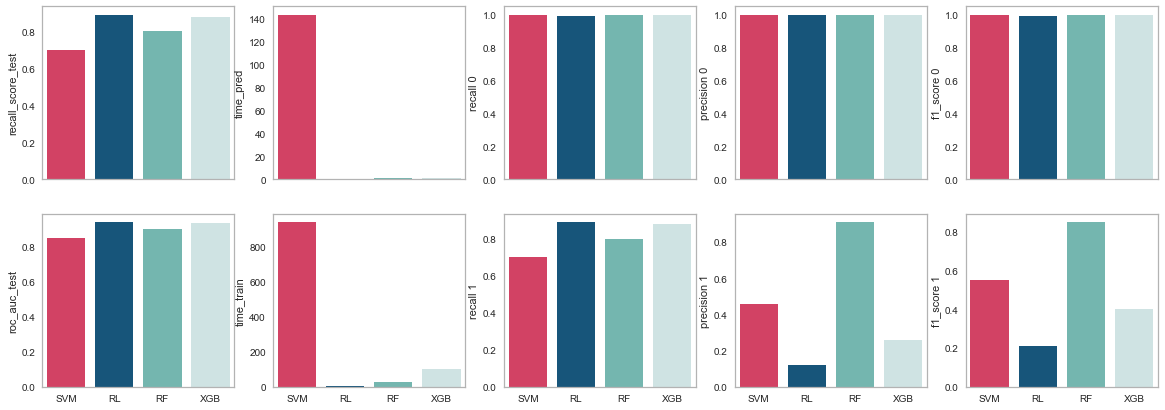

In [29]:
#Transpontando o dataset para plotar
df_scoreT = df_score.T
#Renomeando os algoritmos
df_scoreT.rename(index={
    'SVC': 'SVM',
    'LogisticRegression': 'RL',
    'RandomForestClassifier': 'RF',
    'XGBClassifier': 'XGB'
    
}, inplace=True)

#Verificando a distribuição das features
fig, axes = plt.subplots(2, 5, figsize=(20, 7), sharex=True)
sns.barplot( x=df_scoreT.index, y='recall_score_test', 
            data=df_scoreT, ax=axes[0, 0], palette=palette)
sns.barplot( x=df_scoreT.index, y='roc_auc_test', 
            data=df_scoreT, ax=axes[1, 0], palette=palette)

sns.barplot( x=df_scoreT.index, y='time_pred', 
            data=df_scoreT, ax=axes[0, 1], palette=palette)
sns.barplot( x=df_scoreT.index, y='time_train', 
            data=df_scoreT, ax=axes[1, 1], palette=palette)

sns.barplot( x=df_scoreT.index, y='recall 0', 
            data=df_scoreT, ax=axes[0, 2], palette=palette)
sns.barplot( x=df_scoreT.index, y='recall 1', 
            data=df_scoreT, ax=axes[1, 2], palette=palette);

sns.barplot( x=df_scoreT.index, y='precision 0', 
            data=df_scoreT, ax=axes[0, 3], palette=palette)
sns.barplot( x=df_scoreT.index, y='precision 1', 
            data=df_scoreT, ax=axes[1, 3], palette=palette);

sns.barplot( x=df_scoreT.index, y='f1_score 0', 
            data=df_scoreT, ax=axes[0, 4], palette=palette)
sns.barplot( x=df_scoreT.index, y='f1_score 1', 
            data=df_scoreT, ax=axes[1, 4], palette=palette);

### Dataframe 3: df_undersample50

In [30]:
# Inicializando os modelos
clf_SVM = SVC(random_state=96)
clf_RL= LogisticRegression(random_state=96)
clf_RF = RandomForestClassifier(random_state=96)
clf_XGB = XGBClassifier(random_state=96)

# Coleta os resultados dos algoritmos
results = {}
for clf in [
    clf_SVM, clf_RL, 
    clf_RF, clf_XGB
]:
    clf_model = clf.__class__.__name__
    results[clf_model] = train_predict(clf, under50_X, X_test, under50_y, y_test)

#Cria uma dataframe para os resultados
df_score = pd.DataFrame(results)  
df_score

C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,SVC,LogisticRegression,RandomForestClassifier,XGBClassifier
f1_score 0,0.980000,0.980000,0.990000,0.990000
f1_score 1,0.070000,0.090000,0.130000,0.100000
precision 0,1.000000,1.000000,1.000000,1.000000
precision 1,0.030000,0.050000,0.070000,0.050000
recall 0,0.960000,0.970000,0.980000,0.970000
recall 1,0.930000,0.900000,0.860000,0.900000
recall_score_test,0.925170,0.904762,0.857143,0.897959
roc_auc_test,0.940228,0.936460,0.919040,0.934764
time_pred,1.664166,0.008001,0.117012,0.334033
time_train,0.028003,0.006001,0.029003,0.165016


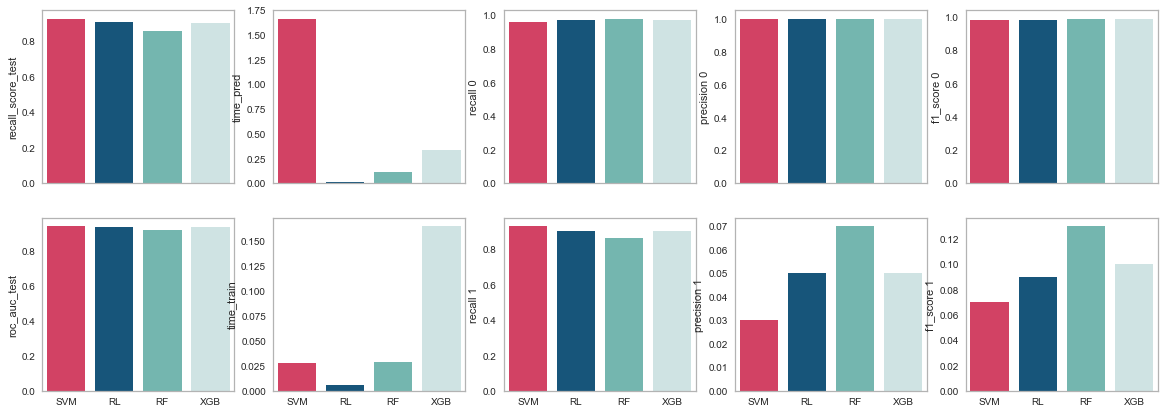

In [31]:
#Transpontando o dataset para plotar
df_scoreT = df_score.T
#Renomeando os algoritmos
df_scoreT.rename(index={
    'SVC': 'SVM',
    'LogisticRegression': 'RL',
    'RandomForestClassifier': 'RF',
    'XGBClassifier': 'XGB'
    
}, inplace=True)

#Verificando a distribuição das features
fig, axes = plt.subplots(2, 5, figsize=(20, 7), sharex=True)
sns.barplot( x=df_scoreT.index, y='recall_score_test', 
            data=df_scoreT, ax=axes[0, 0], palette=palette)
sns.barplot( x=df_scoreT.index, y='roc_auc_test', 
            data=df_scoreT, ax=axes[1, 0], palette=palette)

sns.barplot( x=df_scoreT.index, y='time_pred', 
            data=df_scoreT, ax=axes[0, 1], palette=palette)
sns.barplot( x=df_scoreT.index, y='time_train', 
            data=df_scoreT, ax=axes[1, 1], palette=palette)

sns.barplot( x=df_scoreT.index, y='recall 0', 
            data=df_scoreT, ax=axes[0, 2], palette=palette)
sns.barplot( x=df_scoreT.index, y='recall 1', 
            data=df_scoreT, ax=axes[1, 2], palette=palette);

sns.barplot( x=df_scoreT.index, y='precision 0', 
            data=df_scoreT, ax=axes[0, 3], palette=palette)
sns.barplot( x=df_scoreT.index, y='precision 1', 
            data=df_scoreT, ax=axes[1, 3], palette=palette);

sns.barplot( x=df_scoreT.index, y='f1_score 0', 
            data=df_scoreT, ax=axes[0, 4], palette=palette)
sns.barplot( x=df_scoreT.index, y='f1_score 1', 
            data=df_scoreT, ax=axes[1, 4], palette=palette);

### Dataframe 4: df_undersample33

In [32]:
# Inicializando os modelos
clf_SVM = SVC(random_state=96)
clf_RL= LogisticRegression(random_state=96)
clf_RF = RandomForestClassifier(random_state=96)
clf_XGB = XGBClassifier(random_state=96)

# Coleta os resultados dos algoritmos
results = {}
for clf in [
    clf_SVM, clf_RL,
    clf_RF, clf_XGB
]:
    clf_model = clf.__class__.__name__
    results[clf_model] = train_predict(clf, under33_X, X_test, under33_y, y_test)

#Cria uma dataframe para os resultados
df_score = pd.DataFrame(results)  
df_score

C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,SVC,LogisticRegression,RandomForestClassifier,XGBClassifier
f1_score 0,0.990000,0.990000,0.990000,0.990000
f1_score 1,0.100000,0.130000,0.190000,0.160000
precision 0,1.000000,1.000000,1.000000,1.000000
precision 1,0.050000,0.070000,0.100000,0.090000
recall 0,0.970000,0.980000,0.990000,0.980000
recall 1,0.880000,0.900000,0.860000,0.890000
recall_score_test,0.884354,0.904762,0.863946,0.891156
roc_auc_test,0.928507,0.942017,0.925583,0.937489
time_pred,1.771177,0.008001,0.154016,0.335034
time_train,0.071007,0.009001,0.044004,0.287029


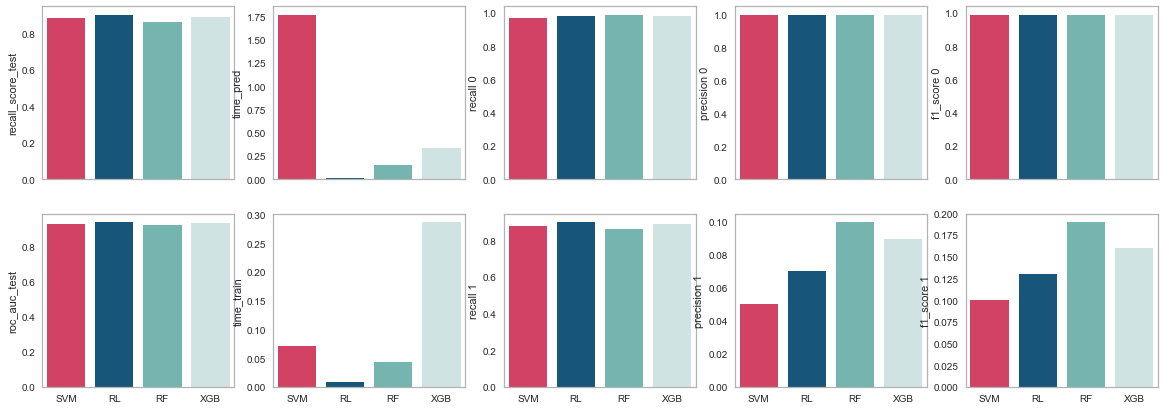

In [33]:
#Transpontando o dataset para plotar
df_scoreT = df_score.T
#Renomeando os algoritmos
df_scoreT.rename(index={
    'SVC': 'SVM',
    'LogisticRegression': 'RL',
    'RandomForestClassifier': 'RF',
    'XGBClassifier': 'XGB'
    
}, inplace=True)

#Verificando a distribuição das features
fig, axes = plt.subplots(2, 5, figsize=(20, 7), sharex=True)
sns.barplot( x=df_scoreT.index, y='recall_score_test', 
            data=df_scoreT, ax=axes[0, 0], palette=palette)
sns.barplot( x=df_scoreT.index, y='roc_auc_test', 
            data=df_scoreT, ax=axes[1, 0], palette=palette)

sns.barplot( x=df_scoreT.index, y='time_pred', 
            data=df_scoreT, ax=axes[0, 1], palette=palette)
sns.barplot( x=df_scoreT.index, y='time_train', 
            data=df_scoreT, ax=axes[1, 1], palette=palette)

sns.barplot( x=df_scoreT.index, y='recall 0', 
            data=df_scoreT, ax=axes[0, 2], palette=palette)
sns.barplot( x=df_scoreT.index, y='recall 1', 
            data=df_scoreT, ax=axes[1, 2], palette=palette);

sns.barplot( x=df_scoreT.index, y='precision 0', 
            data=df_scoreT, ax=axes[0, 3], palette=palette)
sns.barplot( x=df_scoreT.index, y='precision 1', 
            data=df_scoreT, ax=axes[1, 3], palette=palette);

sns.barplot( x=df_scoreT.index, y='f1_score 0', 
            data=df_scoreT, ax=axes[0, 4], palette=palette)
sns.barplot( x=df_scoreT.index, y='f1_score 1', 
            data=df_scoreT, ax=axes[1, 4], palette=palette);

### Dataframe 5: df_oversample50

In [34]:
# Inicializando os modelos
clf_SVM = SVC(random_state=96)
clf_RL= LogisticRegression(random_state=96)
clf_RF = RandomForestClassifier(random_state=96)
clf_XGB = XGBClassifier(random_state=96)

# Coleta os resultados dos algoritmos
results = {}
for clf in [
    clf_SVM, clf_RL, 
    clf_RF, clf_XGB
]:
    clf_model = clf.__class__.__name__
    results[clf_model] = train_predict(clf, over50_X, X_test, over50_y, y_test)

#Cria uma dataframe para os resultados
df_score = pd.DataFrame(results)  
df_score

C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,SVC,LogisticRegression,RandomForestClassifier,XGBClassifier
f1_score 0,1.000000,0.990000,1.000000,1.000000
f1_score 1,0.540000,0.120000,0.840000,0.410000
precision 0,1.000000,1.000000,1.000000,1.000000
precision 1,0.450000,0.070000,0.960000,0.270000
recall 0,1.000000,0.980000,1.000000,1.000000
recall 1,0.690000,0.910000,0.740000,0.860000
recall_score_test,0.693878,0.911565,0.741497,0.863946
roc_auc_test,0.846194,0.944510,0.870719,0.929974
time_pred,145.773576,0.052005,0.881088,1.830183
time_train,3569.323327,4.796480,21.281128,114.765475


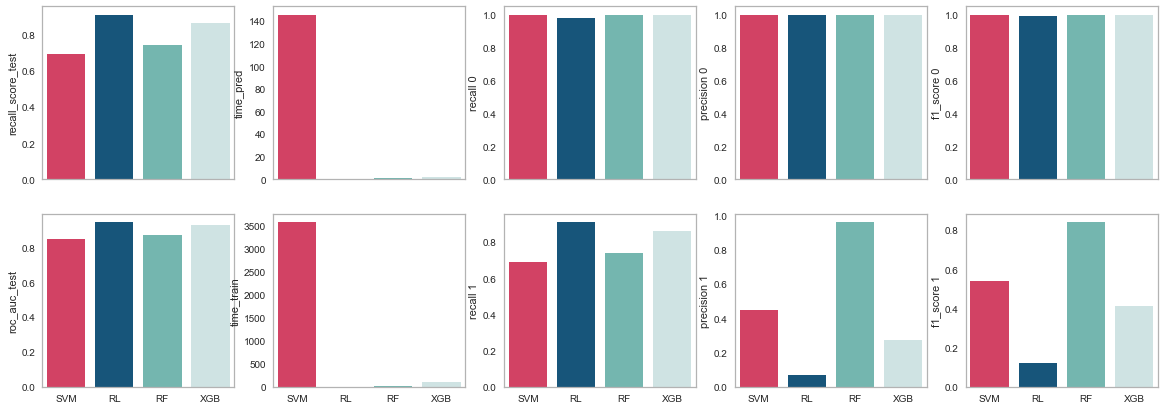

In [35]:
#Transpontando o dataset para plotar
df_scoreT = df_score.T
#Renomeando os algoritmos
df_scoreT.rename(index={
    'SVC': 'SVM',
    'LogisticRegression': 'RL',
    'RandomForestClassifier': 'RF',
    'XGBClassifier': 'XGB'
    
}, inplace=True)

#Verificando a distribuição das features
fig, axes = plt.subplots(2, 5, figsize=(20, 7), sharex=True)
sns.barplot( x=df_scoreT.index, y='recall_score_test', 
            data=df_scoreT, ax=axes[0, 0], palette=palette)
sns.barplot( x=df_scoreT.index, y='roc_auc_test', 
            data=df_scoreT, ax=axes[1, 0], palette=palette)

sns.barplot( x=df_scoreT.index, y='time_pred', 
            data=df_scoreT, ax=axes[0, 1], palette=palette)
sns.barplot( x=df_scoreT.index, y='time_train', 
            data=df_scoreT, ax=axes[1, 1], palette=palette)

sns.barplot( x=df_scoreT.index, y='recall 0', 
            data=df_scoreT, ax=axes[0, 2], palette=palette)
sns.barplot( x=df_scoreT.index, y='recall 1', 
            data=df_scoreT, ax=axes[1, 2], palette=palette);

sns.barplot( x=df_scoreT.index, y='precision 0', 
            data=df_scoreT, ax=axes[0, 3], palette=palette)
sns.barplot( x=df_scoreT.index, y='precision 1', 
            data=df_scoreT, ax=axes[1, 3], palette=palette);

sns.barplot( x=df_scoreT.index, y='f1_score 0', 
            data=df_scoreT, ax=axes[0, 4], palette=palette)
sns.barplot( x=df_scoreT.index, y='f1_score 1', 
            data=df_scoreT, ax=axes[1, 4], palette=palette);

### Dataframe 6: df_oversample33

In [36]:
# Inicializando os modelos
clf_SVM = SVC(random_state=96)
clf_RL= LogisticRegression(random_state=96)
clf_RF = RandomForestClassifier(random_state=96)
clf_XGB = XGBClassifier(random_state=96)

# Coleta os resultados dos algoritmos
results = {}
for clf in [
    clf_SVM, clf_RL, 
    clf_RF, clf_XGB
]:
    clf_model = clf.__class__.__name__
    results[clf_model] = train_predict(clf, over33_X, X_test, over33_y, y_test)

#Cria uma dataframe para os resultados
df_score = pd.DataFrame(results)  
df_score

C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,SVC,LogisticRegression,RandomForestClassifier,XGBClassifier
f1_score 0,1.000000,0.990000,1.000000,1.000000
f1_score 1,0.540000,0.230000,0.840000,0.550000
precision 0,1.000000,1.000000,1.000000,1.000000
precision 1,0.450000,0.130000,0.960000,0.400000
recall 0,1.000000,0.990000,1.000000,1.000000
recall 1,0.690000,0.880000,0.760000,0.860000
recall_score_test,0.693878,0.884354,0.755102,0.857143
roc_auc_test,0.846194,0.937036,0.877522,0.927475
time_pred,131.111866,0.039004,0.662066,1.482148
time_train,3172.479302,4.376438,24.792479,92.501249


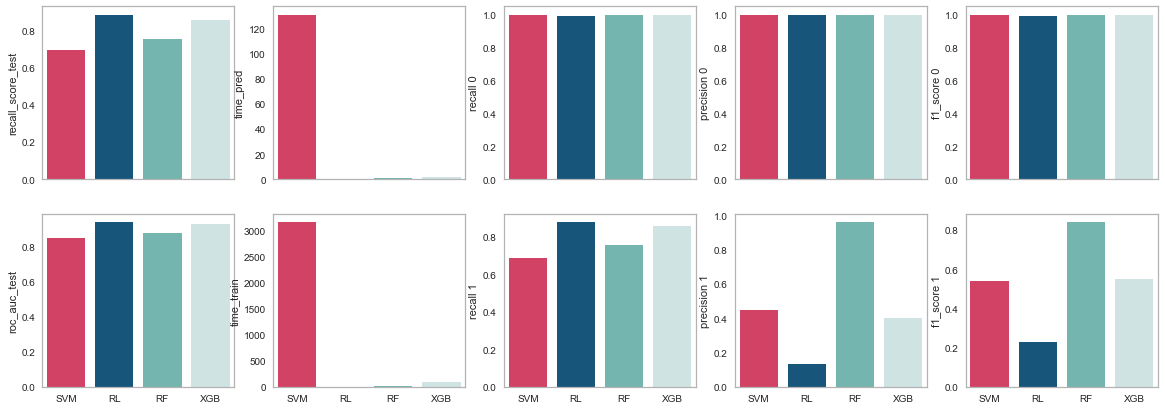

In [37]:
#Transpontando o dataset para plotar
df_scoreT = df_score.T
#Renomeando os algoritmos
df_scoreT.rename(index={
    'SVC': 'SVM',
    'LogisticRegression': 'RL',
    'RandomForestClassifier': 'RF',
    'XGBClassifier': 'XGB'
    
}, inplace=True)

#Verificando a distribuição das features
fig, axes = plt.subplots(2, 5, figsize=(20, 7), sharex=True)
sns.barplot( x=df_scoreT.index, y='recall_score_test', 
            data=df_scoreT, ax=axes[0, 0], palette=palette)
sns.barplot( x=df_scoreT.index, y='roc_auc_test', 
            data=df_scoreT, ax=axes[1, 0], palette=palette)

sns.barplot( x=df_scoreT.index, y='time_pred', 
            data=df_scoreT, ax=axes[0, 1], palette=palette)
sns.barplot( x=df_scoreT.index, y='time_train', 
            data=df_scoreT, ax=axes[1, 1], palette=palette)

sns.barplot( x=df_scoreT.index, y='recall 0', 
            data=df_scoreT, ax=axes[0, 2], palette=palette)
sns.barplot( x=df_scoreT.index, y='recall 1', 
            data=df_scoreT, ax=axes[1, 2], palette=palette);

sns.barplot( x=df_scoreT.index, y='precision 0', 
            data=df_scoreT, ax=axes[0, 3], palette=palette)
sns.barplot( x=df_scoreT.index, y='precision 1', 
            data=df_scoreT, ax=axes[1, 3], palette=palette);

sns.barplot( x=df_scoreT.index, y='f1_score 0', 
            data=df_scoreT, ax=axes[0, 4], palette=palette)
sns.barplot( x=df_scoreT.index, y='f1_score 1', 
            data=df_scoreT, ax=axes[1, 4], palette=palette);

Podemos concluir observando que o algoritmo RL unido com a técnica de reamostragem Smote with Tomek Links com balanceamento de classes iguais, obteve a melhor pontuação de ROC AUC (0,947), contudo o f1_score para classe 1 foi muito baixo, sendo 0,110, portanto o algoritmo escolhido foi o que desempenhou os melhores resultados balanceados entre as duas métricas, sendo o algoritmo RF com a mesma técnica de reamostragem do modelo acima, obtendo o ROC AUC em 0,905 e f1_score em 0,850, com o tempo de treinamento e predição dos dados mediano


----
## Refinamento

Tendo o modelo e técnica de reamostragem definidas o passo seguinte foi a otimização do algoritmo, para isso foi utilizado a biblioteca *GridSearch* do *sklearn*. Aqui se faz importante ressaltar que uma vez que nossa métrica de avaliação será *ROC AUC*, tendo um algoritmo escolhido, utilizaremos a predição dele com probabilidade, que no caso do XBG é `predict_proba`, isso porque como explicado no capítulo de **Métricas de avaliação**, a curva *ROC AUC* é feita variando o *threshold* (limite) para encontrar as taxas de falso positivo / negativo, calculando as probabilidades para cada classe.


O resultado da ROC AUC com `predict_proba` no modelo sem refinamento foi 0.9439, com os seguintes hiperparametros:

In [38]:
print(clf_RF) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=96, verbose=0, warm_start=False)


Modelo não otimizado nos Dados Originais Original 
------
ROC_AUC_Score nos dados de teste: 0.9439

Classification Report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.89      0.81      0.85       147

   micro avg       1.00      1.00      1.00     85443
   macro avg       0.94      0.90      0.92     85443
weighted avg       1.00      1.00      1.00     85443



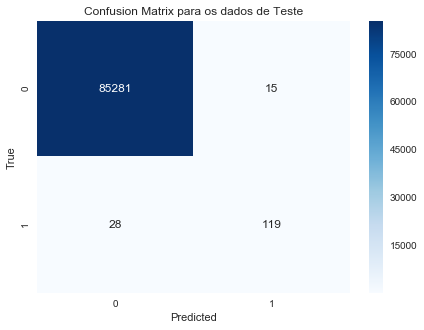

In [38]:
# Realizar predições no modelo não otimizado com probabilidade e class
clf_proba = clf_RF.fit(smote50_X, smote50_y.values.ravel()).predict_proba(X_test)[:,1]
clf_class = clf_RF.fit(smote50_X, smote50_y.values.ravel()).predict(X_test)

# Reportar o score
print ("Modelo não otimizado nos Dados Originais Original \n------")
print ("ROC_AUC_Score nos dados de teste: {:.4f}".format(
    roc_auc_score(y_test, clf_proba)))

# Fazer um heatmap e reporte classificação 
cm_test = confusion_matrix(y_test, clf_class)


plt.figure(figsize=(7,5))
sns.heatmap(cm_test, 
            annot = True, 
            cmap = 'Blues', 
            xticklabels = ['0','1'], 
            yticklabels = ['0','1'],
            fmt = '.0f')
plt.title('Confusion Matrix para os dados de Teste')
plt.ylabel('True')
plt.xlabel('Predicted')

print("\nClassification Report\n")
print(classification_report(y_test, clf_class))

In [40]:
parameters = {
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf':  [4, 5, 6],
             }

# Busca melhores parametros em parameters com scoring em ROC AUC 
grid_obj = GridSearchCV(clf_RF, 
                        parameters, scoring='roc_auc',
                        n_jobs=4,iid=False, cv=5)

# Otimizar os parâmetros 
grid_fit = grid_obj.fit(smote50_X,smote50_y.values.ravel())

# Recuperar o estimador e fazer o predict
best_clf = grid_fit.best_estimator_
best_predictions = best_clf.predict_proba(X_test)[:,1]


print ("\nModelo otimizado\n------")
print ("ROC_AUC_Score final nos dados de teste: {:.4f}".format(
    roc_auc_score(y_test, best_predictions)))



Modelo otimizado
------
ROC_AUC_Score final nos dados de teste: 0.9591


In [41]:
print(best_clf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=96, verbose=0, warm_start=False)


In [45]:
parameters = {
    'max_depth': [5, 10, 15, 20]
             }

# Busca melhores parametros em parameters com scoring em ROC AUC 
grid_obj = GridSearchCV(RandomForestClassifier(
            min_samples_leaf=5, 
            min_samples_split=2), 
                        parameters, scoring='roc_auc',
                        n_jobs=4,iid=False, cv=5)

# Otimizar os parâmetros 
grid_fit = grid_obj.fit(smote50_X,smote50_y.values.ravel())

# Recuperar o estimador e fazer o predict
best_clf = grid_fit.best_estimator_
best_predictions = best_clf.predict_proba(X_test)[:,1]


print ("\nModelo otimizado\n------")
print ("ROC_AUC_Score final nos dados de teste: {:.4f}".format(
    roc_auc_score(y_test, best_predictions)))

C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Modelo otimizado
------
ROC_AUC_Score final nos dados de teste: 0.9512


In [46]:
print(best_clf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [47]:
parameters = {
    'max_features': ['auto', 'sqrt']
             }

# Busca melhores parametros em parameters com scoring em ROC AUC 
grid_obj = GridSearchCV(RandomForestClassifier(
            min_samples_leaf=5, 
            min_samples_split=2,
            max_depth=10), 
                        parameters, scoring='roc_auc',
                        n_jobs=4,iid=False, cv=5)

# Otimizar os parâmetros 
grid_fit = grid_obj.fit(smote50_X,smote50_y.values.ravel())

# Recuperar o estimador e fazer o predict
best_clf = grid_fit.best_estimator_
best_predictions = best_clf.predict_proba(X_test)[:,1]


print ("\nModelo otimizado\n------")
print ("ROC_AUC_Score final nos dados de teste: {:.4f}".format(
    roc_auc_score(y_test, best_predictions)))

C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Modelo otimizado
------
ROC_AUC_Score final nos dados de teste: 0.9627


In [48]:
print(best_clf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [40]:
parameters = {
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)],
             }

# Busca melhores parametros em parameters com scoring em ROC AUC 
grid_obj = GridSearchCV(RandomForestClassifier(
            min_samples_leaf=5, 
            min_samples_split=2,
            max_depth=10,
            max_features='auto'), 
                        parameters, scoring='roc_auc',
                        n_jobs=4,iid=False, cv=5)

# Otimizar os parâmetros 
grid_fit = grid_obj.fit(smote50_X,smote50_y.values.ravel())

# Recuperar o estimador e fazer o predict
best_clf = grid_fit.best_estimator_
best_predictions = best_clf.predict_proba(X_test)[:,1]


print ("\nModelo otimizado\n------")
print ("ROC_AUC_Score final nos dados de teste: {:.4f}".format(
    roc_auc_score(y_test, best_predictions)))


Modelo otimizado
------
ROC_AUC_Score final nos dados de teste: 0.9823


In [100]:
num = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
for i in num:
    print(i)

200
288
377
466
555
644
733
822
911
1000


Com a otimização do modelo feito no passo anterior, o resultado final da ROC AUC com predict_proba no modelo otimizado foi 0.9823, com os seguintes hiperparametros:

In [41]:
print(best_clf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=822, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)



Classification Report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.63      0.84      0.72       147

   micro avg       1.00      1.00      1.00     85443
   macro avg       0.82      0.92      0.86     85443
weighted avg       1.00      1.00      1.00     85443



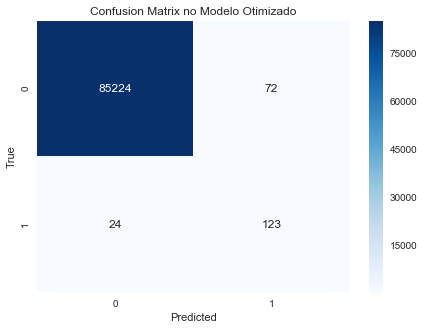

In [42]:
# Realizar predições no modelo otimizado com class
clf_class = best_clf.predict(X_test)

# Fazer um heatmap e reporte classificação 
cm_test = confusion_matrix(y_test, clf_class)


plt.figure(figsize=(7,5))
sns.heatmap(cm_test, 
            annot = True, 
            cmap = 'Blues', 
            xticklabels = ['0','1'], 
            yticklabels = ['0','1'],
            fmt = '.0f')
plt.title('Confusion Matrix no Modelo Otimizado')
plt.ylabel('True')
plt.xlabel('Predicted')

print("\nClassification Report\n")
print(classification_report(y_test, clf_class))

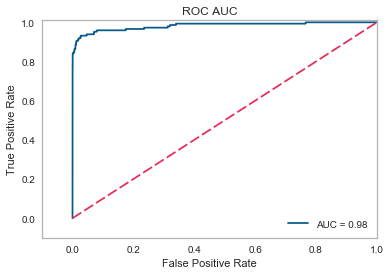

In [77]:
# ROC AUC CURVE
fpr, tpr, thresholds = roc_curve(y_test,best_predictions)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('ROC AUC')
plt.plot(fpr, tpr,color='#06598b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1], '#ea2a58', dashes=[6,2])
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


### Features Importance

Para verificar quais *features* possuim maior relevância no modelo, vamos utilizar uma ferramente do *sklearn* chamada `feature_importance_`, que calcula a importância de cada variável, fazendo um ranking

In [44]:
# Treinar o modelo utilizando o conjunto de treinamento
model = clf_RF.fit(smote50_X, smote50_y.values.ravel())

# Extrair a importância dos atributos utilizando .feature_importances_ 
importances = model.feature_importances_

C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Ao verificar a relevância de cada feature no modelo o resultado foi que 5 atributos acumulavam 70% da importância dos dados, como podemos ver na Figura 11

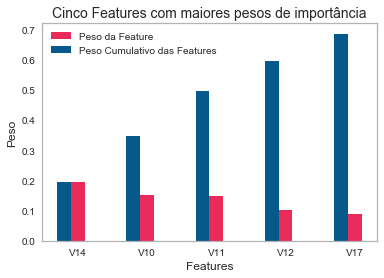

In [94]:
indices = np.argsort(importances)[::-1]
columns = smote50_X.columns.values[indices[:5]]
values = importances[indices][:5]

# Creat the plot
fig = plt.figure(figsize = (6,4))
plt.title("Cinco Features com maiores pesos de importância", fontsize = 14)
plt.bar(np.arange(5), values, width = 0.2, align="center",  \
      label = "Peso da Feature")
plt.bar(np.arange(5) - 0.2, np.cumsum(values), width = 0.2, align = "center",  \
      label = "Peso Cumulativo das Features")
plt.xticks(np.arange(5), columns)
plt.ylabel("Peso", fontsize = 12)
plt.xlabel("Features", fontsize = 12)
plt.legend(loc = 'upper left')
plt.show() 

In [97]:
# Importar a funcionalidade para clonar um modelo
from sklearn.base import clone

# Reduzir a quantidade de atributos
X_train_reduced = smote50_X[columns]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Treinar o melhor modelo encontrado com a busca grid anterior
clf = (clone(best_clf)).fit(X_train_reduced, smote50_y.values.ravel())

# Fazer novas predições
reduced_predictions = clf.predict(X_test_reduced)

# Reportar os scores do modelo final utilizando as duas versões dos dados.

print ("\nModelo otimizado\n------")
print ("ROC_AUC_Score final nos dados de teste: {:.4f}".format(
    roc_auc_score(y_test, best_predictions)))

print ("\nModelo reduzido\n------")
print ("ROC_AUC_Score final nos dados de teste do modelo reduzido: {:.4f}".format(
    roc_auc_score(y_test, reduced_predictions)))


Modelo otimizado
------
ROC_AUC_Score final nos dados de teste: 0.9823

Modelo reduzido
------
ROC_AUC_Score final nos dados de teste do modelo reduzido: 0.9182


Contudo ao utilizar o mesmo modelo com apenas as 5 features o ROC AUC caiu para 0.9182, devido a grande diferença da métrica de ambos modelos, foi escolhido o modelo otimizado com todas as features

#### Resultados:

Comparando o modelo final com benchmark e o modelo não otimizado, conclui-se que obteve uma melhora no resultado, sendo 95% no benchmark e 98% no modelo final, tais resultados podem ser vistos na tabela abaixo.

|Métrica | Benchmark | Modelo não Otimizado  | Modelo Otimziado |
| :------------: | :------------:|:------------: | :------------: | 
| ROC AUC |   95%   |  94%  | 98%  |